##Importing libraries

In [ ]:
# general
import matplotlib.pyplot as plt
import numpy as np
import re
import pickle

from collections import Counter, defaultdict
from tqdm.notebook import tqdm
from typing import *

# torch
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
#Reproducing same results
SEED = 42

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [ ]:
# Let's create a new folder and download the dataset.
! mkdir data
! wget -O data/train.jsonl https://raw.githubusercontent.com/SapienzaNLP/nlp2021-hw1/main/data/train.jsonl
! wget -O data/dev.jsonl https://raw.githubusercontent.com/SapienzaNLP/nlp2021-hw1/main/data/dev.jsonl

--2021-05-03 12:35:30--  https://raw.githubusercontent.com/SapienzaNLP/nlp2021-hw1/main/data/train.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3714370 (3.5M) [text/plain]
Saving to: ‘data/train.jsonl’

data/train.jsonl    100%[===================>]   3.54M  21.7MB/s    in 0.2s    

2021-05-03 12:35:30 (21.7 MB/s) - ‘data/train.jsonl’ saved [3714370/3714370]

--2021-05-03 12:35:30--  https://raw.githubusercontent.com/SapienzaNLP/nlp2021-hw1/main/data/dev.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443234 (433K) 

##See the data with pandas

In [ ]:
import pandas as pd
import os
import json

root_folder: str = r"./data" # to save dataset

train_filename = "train.jsonl"
valid_filename = "dev.jsonl"

wic_train_dataframe = pd.read_json(os.sep.join([root_folder, train_filename]), lines=True)
wic_valid_dataframe = pd.read_json(os.sep.join([root_folder, valid_filename]), lines=True)

wic_train_dataframe

id       lemma   pos  ... start2 end2  label
0        train.0        play  NOUN  ...     10   14  False
1        train.1        play  NOUN  ...    112  116  False
2        train.2      esteem  NOUN  ...    106  112   True
3        train.3      esteem  NOUN  ...     20   26   True
4        train.4      holder  NOUN  ...     27   33   True
...          ...         ...   ...  ...    ...  ...    ...
7995  train.7995  positivity  NOUN  ...     43   53   True
7996  train.7996     backing  NOUN  ...     67   75  False
7997  train.7997     backing  NOUN  ...     60   68   True
7998  train.7998        gird  VERB  ...    175  179  False
7999  train.7999        gird  VERB  ...     35   41   True

[8000 rows x 10 columns]

In [ ]:
wic_train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         8000 non-null   object
 1   lemma      8000 non-null   object
 2   pos        8000 non-null   object
 3   sentence1  8000 non-null   object
 4   sentence2  8000 non-null   object
 5   start1     8000 non-null   int64 
 6   end1       8000 non-null   int64 
 7   start2     8000 non-null   int64 
 8   end2       8000 non-null   int64 
 9   label      8000 non-null   object
dtypes: int64(4), object(6)
memory usage: 625.1+ KB


In [ ]:
wic_valid_dataframe

id         lemma   pos  ... start2 end2  label
0      dev.0      superior  NOUN  ...     41   50  False
1      dev.1      superior  NOUN  ...     44   53   True
2      dev.2  acquaintance  NOUN  ...     41   54  False
3      dev.3  acquaintance  NOUN  ...     74   86  False
4      dev.4       baggage  NOUN  ...      6   13   True
..       ...           ...   ...  ...    ...  ...    ...
995  dev.995         crash  NOUN  ...     75   80   True
996  dev.996     calculate  VERB  ...     12   22  False
997  dev.997     calculate  VERB  ...     11   21  False
998  dev.998         click  VERB  ...     92   98   True
999  dev.999         click  VERB  ...     59   66  False

[1000 rows x 10 columns]

In [ ]:
# See the distribution of 'label' in the training set.
wic_train_dataframe.groupby('label').count()

id  lemma   pos  sentence1  sentence2  start1  end1  start2  end2
label                                                                     
False  4000   4000  4000       4000       4000    4000  4000    4000  4000
True   4000   4000  4000       4000       4000    4000  4000    4000  4000

In [ ]:
# See the distribution of 'label' in the dev set.
wic_valid_dataframe.groupby('label').count()

id  lemma  pos  sentence1  sentence2  start1  end1  start2  end2
label                                                                   
False  500    500  500        500        500     500   500     500   500
True   500    500  500        500        500     500   500     500   500

In [ ]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
! mv cc.en.300.vec.gz data/.
! gzip -d data/cc.en.300.vec.gz

--2021-05-03 12:35:42--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  10.3MB/s    in 2m 5s   

2021-05-03 12:37:48 (10.1 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
! wget http://nlp.stanford.edu/data/glove.840B.300d.zip
! unzip -q glove.840B.300d.zip -d ./data

--2021-05-03 09:42:05--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-05-03 09:42:05--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-05-03 09:42:05--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

##Loading the embeddings

In [ ]:
root_folder: str = r"./data" # to save dataset

use_GloVe = True # True ---> use GloVe, False ---> use FastText
word_embs = dict()
embs_file = "glove.840B.300d.txt" if use_GloVe  else "cc.en.300.vec" # Each line of the embedding file contains the word and then its embedding
EMBEDDING_SIZE = 300
with open(os.sep.join([root_folder, embs_file])) as emb_file:

  if not use_GloVe:
    next(emb_file)
  
  for line in emb_file:

    word, *word_emb = line.strip().split(' ')
    word_emb = torch.tensor([float(component_string) for component_string in word_emb])

    if len(word_emb) == EMBEDDING_SIZE:
      word_embs[word] = word_emb

word_embs

{',': tensor([ 1.2500e-01, -1.0790e-01,  2.4500e-02, -2.5290e-01,  1.0570e-01,
         -1.8400e-02,  1.1770e-01, -7.0100e-02, -4.0100e-02, -8.0000e-03,
          7.7200e-02, -2.2600e-02,  8.9300e-02, -4.8700e-02, -8.9700e-02,
         -8.3500e-02,  2.0000e-02,  2.7300e-02, -1.9400e-02,  9.6400e-02,
          8.7500e-02,  9.8000e-03,  4.5300e-02,  1.5500e-02,  1.4620e-01,
          2.2500e-02,  4.4800e-02,  1.3700e-02,  5.7000e-02,  1.7640e-01,
         -1.0720e-01, -8.2600e-02,  1.7300e-02,  1.0900e-01,  2.0700e-02,
         -1.2710e-01,  2.4450e-01,  3.7500e-02, -2.0900e-02, -4.4500e-02,
          5.4000e-02,  1.2820e-01,  4.3700e-02,  5.8800e-02,  9.8400e-02,
          5.3900e-02,  4.0000e-04,  1.2900e-01,  2.4200e-02, -1.2000e-02,
         -4.8000e-02,  3.4600e-02, -6.6400e-02, -3.3000e-02, -6.2500e-02,
         -7.0800e-02, -5.7900e-02,  1.7380e-01,  4.4480e-01,  3.7000e-02,
         -1.0010e-01, -3.2000e-03,  3.5900e-02, -6.8500e-02, -3.6100e-02,
          7.0000e-03,  1.3160e-01

## Loading the dataset

In [ ]:
from string import punctuation

def preprocess_sentence(sentence: str) -> str: # I remove punctuation and lowerize the sentence
    cleaned_sentence = ''
    for char in sentence:
      if char not in punctuation:
        cleaned_sentence = cleaned_sentence + char

    return cleaned_sentence.lower()

In [ ]:
def create_vocab(sentences: np.array, freq_vocab: Dict[str, int]) -> None:
    '''
    It populates the dict freq_vocab as follows:
    - freq_vocab: key: word, value: frequency of this word in the available training sentences
    '''

    for sentence in tqdm(sentences):
        for word in sentence:
            try:
                freq_vocab[word] += 1
            except KeyError:
                freq_vocab[word] = 1

sentences1 = wic_train_dataframe["sentence1"].apply(lambda sentence: preprocess_sentence(sentence).split(' ')).to_numpy()
freq_vocab = {}
create_vocab(sentences1, freq_vocab)
sentences2 = wic_train_dataframe["sentence2"].apply(lambda sentence: preprocess_sentence(sentence).split(' ')).to_numpy()
create_vocab(sentences2, freq_vocab)
print({k: freq_vocab[k] for k in list(freq_vocab)[:10]})


{'in': 9079, 'that': 3963, 'context': 60, 'of': 16087, 'coordination': 27, 'and': 13310, 'integration': 39, 'bolivia': 4, 'holds': 24, 'a': 8990}


In [ ]:
import operator
from math import log

def get_coverage_of_the_vocab(freq_vocab: Dict[str, int], word_embs: Dict[str, torch.Tensor]) -> Dict[str, int]:
    '''
    It computes the coverage provided by the loaded word embeddings wrt the training corpus (sentences in this case).
    It returns also a list of tuples of the structure (word, freq) of the words not covered by the loaded word embeddings sorted in descending order wrt freq (first 20 entries).
    '''
    iv_words = {}
    oov_words = {}
    iv_words_freqs_sum = 0
    oov_words_freqs_sum = 0
    IDF_vocab = {}
    for word in tqdm(freq_vocab):
        try:
            iv_words[word] = word_embs[word]
            iv_words_freqs_sum += freq_vocab[word]
        except:

            oov_words[word] = freq_vocab[word]
            oov_words_freqs_sum += freq_vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(iv_words) / len(freq_vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(iv_words_freqs_sum / (iv_words_freqs_sum + oov_words_freqs_sum)))
    sorted_x = sorted(oov_words.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

oov_words = get_coverage_of_the_vocab(freq_vocab, word_embs)
freq_vocab = defaultdict(lambda: 0, freq_vocab)  # default dict returns 0 (unk token) when unknown word
oov_words[:20]


Found embeddings for 87.98% of vocab
Found embeddings for  98.66% of all text


[('', 125),
 ('unhcr', 35),
 ('secretarygeneral', 30),
 ('iraqs', 15),
 ('asylumseekers', 11),
 ('unctad', 11),
 ('illtreatment', 9),
 ('organization’s', 9),
 ('women’s', 8),
 ('undcp', 8),
 ('sorbian', 8),
 ('oios', 8),
 ('capacitybuilding', 7),
 ('committee’s', 7),
 ('commission’s', 6),
 ('goghs', 6),
 ('world’s', 6),
 ('nuclearweaponfree', 6),
 ('mansuri', 6),
 ('sbsta', 6)]

In [ ]:
Z = sum(freq_vocab.values()) # normalization constant

def sentence2vector(sentence: str, alpha: float=1e-3) -> Optional[torch.Tensor]:
    sentence_word_embs = [(alpha / (alpha + ((freq_vocab[word] + 1) / (Z + 1)))) * word_embs[word] for word in sentence.split(' ') if word in word_embs]

    if len(sentence_word_embs) == 0:
      return None

    sentence_word_embs = torch.stack(sentence_word_embs) # tensor shape: (#words X #features)
    return torch.mean(sentence_word_embs, dim=0) # weighted average

In [ ]:
class WiCDataset(Dataset):

    def __init__(
        self,
        data: pd.DataFrame, # table (dataset)
        sentence1_column: str = 'sentence1',
        sentence2_column: str = 'sentence2',
        label_column: str = 'label',
        num_total_features: int = 4*EMBEDDING_SIZE,
        principal_component: torch.Tensor = None
    ):

        sentences1 = data[sentence1_column]
        sentences2 = data[sentence2_column]
        labels = data[label_column]
        self.num_total_features = num_total_features
        self.principal_component = principal_component
        self.samples = self._preprocess_samples(
            sentences1, sentences2, labels)

    def _preprocess_samples(
        self,
        sentences1: pd.Series, # columns of the table
        sentences2: pd.Series, # columns of the table
        labels: pd.Series
    ):
    
        samples = []
        
        if self.principal_component is None:
          
          embs_matrix = None # It will be a 2D-tensor where, in the row i, there will be the word emb of the preprocessed sentence i computed by the function sentence2vector

          for sentence1, sentence2 in zip(sentences1, sentences2):
            vector1 = sentence2vector(preprocess_sentence(sentence1))
            if vector1 is None:
              continue
            vector2 = sentence2vector(preprocess_sentence(sentence2))
            if vector2 is None:
              continue
              
            embs_matrix = torch.cat((embs_matrix, vector1.unsqueeze(0)), 0) if embs_matrix is not None else vector1.unsqueeze(0)
            embs_matrix = torch.cat((embs_matrix, vector2.unsqueeze(0)), 0)

          self.principal_component = torch.svd(embs_matrix)[2][:, 0].unsqueeze(1) # It is the first column (hence, relative to the first component) of the matrix V in the SVD
        
          embs_matrix_with_removed_pc = embs_matrix - torch.mm(embs_matrix, self.principal_component) * torch.transpose(self.principal_component, 0, 1) # I remove the first component from each sentence embedding

          for i, label in zip(range(0, len(embs_matrix_with_removed_pc), 2), labels):
            vector1 = embs_matrix_with_removed_pc[i]
            vector2 = embs_matrix_with_removed_pc[i + 1]
            input_features = torch.cat((vector1, vector2, torch.abs(vector1 - vector2), vector1 * vector2), 0) # (v1, v2, |v1 - v2|, v1 * v2)
            output_value = np.float32(label == 'True')

            # A sample is composed of the input and output values,
            # that is, the input features and output_value that is 1 if label = True and 0 otherwise.
            sample = (input_features, output_value)
            samples.append(sample)
        else:


          vvt = torch.mm(self.principal_component, torch.transpose(self.principal_component, 0, 1)) #v * v^T matrix, where v is the first singular vector (= self.principal_component)
          for sentence1, sentence2, label in zip(sentences1, sentences2, labels):
              vector1 = sentence2vector(preprocess_sentence(sentence1))
              if vector1 is None:
                continue
              vector2 = sentence2vector(preprocess_sentence(sentence2))
              if vector2 is None:
                continue
              vector1 -= torch.mm(vvt, vector1.unsqueeze(1)).squeeze(1) # I remove from vector1 its the projection to self.principal_component
              vector2 -= torch.mm(vvt, vector2.unsqueeze(1)).squeeze(1)

              input_features = torch.cat((vector1, vector2, torch.abs(vector1 - vector2), vector1 * vector2), 0) # (v1, v2, |v1 - v2|, v1 * v2)
              output_value = np.float32(label == 'True')

              # A sample is composed of the input and output values,
              # that is, the input features and output_value that is 1 if label = True and 0 otherwise.
              sample = (input_features, output_value)
              samples.append(sample)
        
        return samples
            

    def __len__(self):
        # returns the number of samples in our dataset
      return len(self.samples)

    def __getitem__(self, idx):
        # returns the idx-th sample
        return self.samples[idx]

    def get_principal_component(self):
      # returns the principal component computed from the training set
      return self.principal_component


In [ ]:
train_dataset = WiCDataset(data=wic_train_dataframe)

valid_dataset = WiCDataset(data=wic_valid_dataframe, principal_component=train_dataset.get_principal_component())

train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True) # I shuffle because I have seen that in the sentence1 col, each sentence is reapeted twice consecutively. So I shuffle in roder to add randomicity.
valid_dataloader = DataLoader(valid_dataset, batch_size=2048, shuffle=True)


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

@torch.no_grad()
def evaluate_loss_and_accuracy(
    model: nn.Module,
    dataloader: DataLoader,
    evaluate_final_model: bool = False
) -> Union[Tuple[float, float], Tuple[Tuple[float, float], np.ndarray, str]]:
    
    losses = []
    correct_predictions = 0
    num_predictions = 0
    y_pred = []
    y_true = []

    for *x, y in dataloader:
        outputs = model(*x, y)
        loss = outputs['loss']
        losses.append(loss)

        #round predictions to the closest integer
        predictions = torch.round(outputs['probabilities'])

        correct_predictions += (predictions == y).sum()
        num_predictions += predictions.shape[0]
        if evaluate_final_model:
          y_pred.extend(predictions.numpy())
          y_true.extend(y.numpy())

    mean_loss = sum(losses) / len(losses)
    accuracy = correct_predictions / num_predictions
    if evaluate_final_model:
      return mean_loss, accuracy, confusion_matrix(y_true, y_pred, labels=[1.0, 0.0]), classification_report(y_true, y_pred, labels=[1.0, 0.0], target_names=["True", "False"])
    return mean_loss, accuracy

In [ ]:
class WiCClassifier(nn.Module):

    def __init__(
        self,
        input_features: int,
        hidden_size: int
    ):
        super().__init__()
        self.hidden_layer = torch.nn.Linear(input_features, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, 1)
        self.loss_fn = torch.nn.BCELoss()
        self.global_epoch = 0

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        hidden_representation = self.hidden_layer(x)
        hidden_representation = torch.relu(hidden_representation)
        # extract the value from the tensor
        logits = self.output_layer(hidden_representation).squeeze(1)
        # we need to apply a sigmoid activation function
        probabilities = torch.sigmoid(logits)
        result = {'logits': logits, 'probabilities': probabilities}

        # compute loss
        if y is not None:
            loss = self.loss(probabilities, y)
            result['loss'] = loss

        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

In [ ]:
! mkdir experiments

In [ ]:

experiments_folder: str = r"./experiments" # to save dataset
model_filename = "model_SIF.pth"
model_filename_path = os.sep.join([experiments_folder, model_filename])


def train_and_evaluate(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    epochs: int = 5,
    valid_dataloader: DataLoader = None, 
    monitor: str = 'val_loss',
    early_stopping: bool = False,
    early_stopping_patience: int = 0,
    verbose: bool = True,
) -> Dict[str, Dict[str, list]]:

    monitor_val_loss = monitor == 'val_loss'
    monitor_val_accuracy = monitor == 'val_accuracy'
    if not monitor_val_loss and not monitor_val_accuracy:
        raise ValueError("results: monitor must be one of {val_loss, val_accuracy}.")

    train_loss_history = []
    train_accuracy_history = []
    valid_loss_history = []
    valid_accuracy_history = []
    patience_counter = 0
    best_loss, best_accuracy = None, None

    for epoch in range(epochs):
        losses = []
        accuracies = []
        correct_predictions = 0
        num_predictions = 0

        # batches of the training set
        for *x, y in train_dataloader:
            optimizer.zero_grad()
            batch_out = model(*x, y)
            loss = batch_out['loss']
            losses.append(loss)
            #round predictions to the closest integer
            predictions = torch.round(batch_out['probabilities'])
            correct_predictions = (predictions == y).sum()
            num_predictions = predictions.shape[0] 
            accuracies.append(correct_predictions / num_predictions) # FOR THE CODE QUALITY: see if it is the case to avoid the re-usage wrt evaluate_loss and evaluate_accuracy functions 

            # computes the gradient of the loss
            loss.backward()
            # updates parameters based on the gradient information
            optimizer.step()

        model.global_epoch += 1
        mean_loss = sum(losses) / len(losses)
        mean_accuracy = sum(accuracies) / len(accuracies)
        train_loss_history.append(mean_loss.item())
        train_accuracy_history.append(mean_accuracy.item())
        if verbose or epoch == epochs - 1:
            print(f'  Epoch {model.global_epoch:3d} => Loss: {mean_loss:0.6f}, Accuracy: {mean_accuracy:0.6f}')
        
        if verbose and valid_dataloader:
            valid_loss, valid_accuracy = evaluate_loss_and_accuracy(model, valid_dataloader)
            if best_loss == None or valid_loss.item() < best_loss:
              best_loss = valid_loss.item()
            if best_accuracy == None or valid_accuracy.item() > best_accuracy:
              best_accuracy = valid_accuracy.item()
            valid_loss_history.append(valid_loss.item())
            valid_accuracy_history.append(valid_accuracy.item())
            print(f'    Validation => Loss: {valid_loss:0.6f}, Accuracy: {valid_accuracy:0.6f}')
            print()

            if early_stopping:
                stop = monitor_val_loss and epoch > 0 and valid_loss_history[-1] > best_loss
                stop = stop or monitor_val_accuracy and epoch > 0 and valid_accuracy_history[-1] < best_accuracy
                if stop:
                    if patience_counter >= early_stopping_patience:
                        print('Early stop.')
                        break
                    else:
                        print('-- Patience.\n')
                        patience_counter += 1
                else:
                  patience_counter = 0
                  torch.save(model.state_dict(), model_filename_path)

    print(("Best loss: " + str(best_loss)) if monitor_val_loss else ("Best accuracy: " + str(best_accuracy)))

    return {'loss': {'train_history': train_loss_history, 'valid_history': valid_loss_history}, 'accuracy': {'train_history': train_accuracy_history, 'valid_history': valid_accuracy_history}}

In [ ]:
model = WiCClassifier(
    input_features=train_dataset.num_total_features,
    hidden_size=600)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=2e-5)

logs = train_and_evaluate(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    early_stopping=True,
    early_stopping_patience=20, # I added a high patience value because I have a low LR
    epochs=3000)

  Epoch   1 => Loss: 0.693251, Accuracy: 0.499697
    Validation => Loss: 0.693198, Accuracy: 0.500000

  Epoch   2 => Loss: 0.693175, Accuracy: 0.500227
    Validation => Loss: 0.693144, Accuracy: 0.500000

  Epoch   3 => Loss: 0.693123, Accuracy: 0.500379
    Validation => Loss: 0.693091, Accuracy: 0.499000

  Epoch   4 => Loss: 0.693061, Accuracy: 0.500295
    Validation => Loss: 0.693042, Accuracy: 0.497000

  Epoch   5 => Loss: 0.692998, Accuracy: 0.500219
    Validation => Loss: 0.692992, Accuracy: 0.493000

  Epoch   6 => Loss: 0.692953, Accuracy: 0.500762
    Validation => Loss: 0.692945, Accuracy: 0.492000

  Epoch   7 => Loss: 0.692897, Accuracy: 0.500909
    Validation => Loss: 0.692898, Accuracy: 0.496000

  Epoch   8 => Loss: 0.692841, Accuracy: 0.500922
    Validation => Loss: 0.692851, Accuracy: 0.498000

  Epoch   9 => Loss: 0.692788, Accuracy: 0.503536
    Validation => Loss: 0.692804, Accuracy: 0.501000

  Epoch  10 => Loss: 0.692731, Accuracy: 0.507004
    Validation

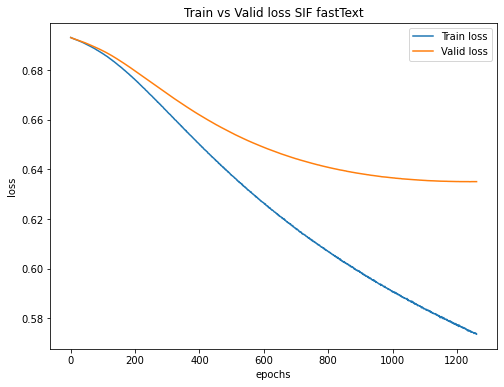

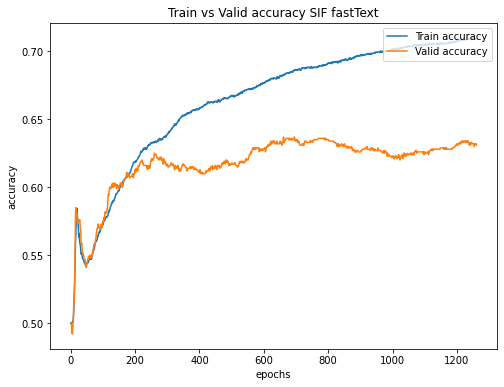

In [ ]:
def plot_logs(logs: Dict, title: str, metric: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(logs['train_history']))), logs['train_history'], label='Train ' + metric)
    plt.plot(list(range(len(logs['valid_history']))), logs['valid_history'], label='Valid ' + metric)
    
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.legend(loc="upper right")

    plt.show()

plot_logs(logs['loss'], 'Train vs Valid loss SIF', 'loss')
plot_logs(logs['accuracy'], 'Train vs Valid accuracy SIF', 'accuracy')

In [ ]:
model = WiCClassifier(
    input_features=train_dataset.num_total_features,
    hidden_size=600)
model.load_state_dict(torch.load(model_filename_path)) # Load best model seen during training wrt valid loss

valid_loss, valid_accuracy, confusion_matrix, classification_report = evaluate_loss_and_accuracy(model, valid_dataloader, True) # Evaluate loaded model
print(f'Validation => Loss: {valid_loss:0.6f}, Accuracy: {valid_accuracy:0.6f}')

Validation => Loss: 0.635032, Accuracy: 0.631000


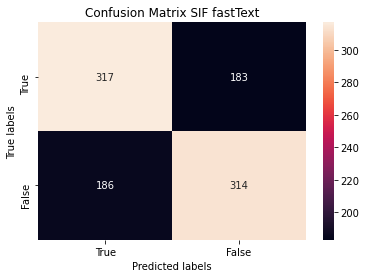

In [ ]:
# Plot confusion matrix
import seaborn as sns


ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix SIF')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
plt.savefig(image_path, dpi=300, bbox_inches='tight')

In [ ]:
print(classification_report)

              precision    recall  f1-score   support

        True       0.63      0.63      0.63       500
       False       0.63      0.63      0.63       500

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000

